# test the learned policy by playing back the interaction

In [1]:
import time
import joblib
import os
import os.path as osp
import tensorflow as tf
from spinup import EpochLogger
from spinup.utils.logx import restore_tf_graph

def load_policy(fpath, itr='last', deterministic=False):

    # handle which epoch to load from
    if itr=='last':
        saves = [int(x[11:]) for x in os.listdir(fpath) if 'simple_save' in x and len(x)>11]
        itr = '%d'%max(saves) if len(saves) > 0 else ''
    else:
        itr = '%d'%itr

    # load the things!
    sess = tf.Session()
    model = restore_tf_graph(sess, osp.join(fpath, 'simple_save'+itr))

    # get the correct op for executing actions
    if deterministic and 'mu' in model.keys():
        # 'deterministic' is only a valid option for SAC policies
        print('Using deterministic action op.')
        action_op = model['mu']
    else:
        print('Using default action op.')
        action_op = model['pi']

    # make function for producing an action given a single state
    get_action = lambda x : sess.run(action_op, feed_dict={model['x']: x[None,:]})[0]

    # try to load environment from save
    # (sometimes this will fail because the environment could not be pickled)
    try:
        state = joblib.load(osp.join(fpath, 'vars'+itr+'.pkl'))
        env = state['env']
    except:
        env = None

    return env, get_action


from IPython import display
import matplotlib
import matplotlib.pyplot as plt


def run_policy(env, get_action, max_ep_len=None, num_episodes=100, render=True):

    assert env is not None, \
        "Environment not found!\n\n It looks like the environment wasn't saved, " + \
        "and we can't run the agent in it. :( \n\n Check out the readthedocs " + \
        "page on Experiment Outputs for how to handle this situation."

    logger = EpochLogger()
    o, r, d, ep_ret, ep_len, n = env.reset(), 0, False, 0, 0, 0
    
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once

    
    while n < num_episodes:
        if render:
            img.set_data(env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
#            time.sleep(1e-3)

        a = get_action(o)
        o, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpLen=ep_len)
            print('Episode %d \t EpRet %.3f \t EpLen %d'%(n, ep_ret, ep_len))
            o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
            n += 1

    logger.log_tabular('EpRet', with_min_and_max=True)
    logger.log_tabular('EpLen', average_only=True)
    logger.dump_tabular()

In [2]:
%matplotlib inline

Episode 1 	 EpRet -94.926 	 EpLen 358
-------------------------------------
|    AverageEpRet |            46.1 |
|        StdEpRet |             141 |
|        MaxEpRet |             187 |
|        MinEpRet |           -94.9 |
|           EpLen |             440 |
-------------------------------------


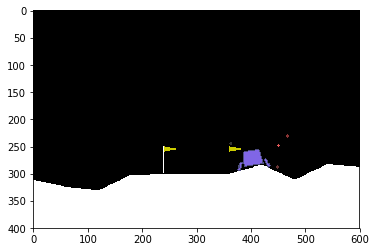

In [3]:
#fpath = '/app/spinningup/data/installtest/installtest_s0'
fpath = '/app/spinningup/data/LunarLanderContinuous-v2-ddpg-bench_lunarlandercontinuous-v2_hid64-64_tanh/LunarLanderContinuous-v2-ddpg-bench_lunarlandercontinuous-v2_hid64-64_tanh_s0'
env, get_action = load_policy(fpath, 
                              'last',
                              True)
run_policy(env, get_action, 0, 2, True)